In [1]:
import pandas as pd
import numpy as np
import ast
from matplotlib import pyplot as plt
import sys
sys.path.append('../src/')
import data_layer

In [2]:
from tueplots import bundles
plt.rcParams.update(bundles.icml2022())

In [3]:
MIN_OCCURENCES=5

In [4]:
df_wiki = pd.read_csv("../dat/wiki/graph.csv")
df_llm = pd.read_json("../dat/llm/graph.json")
df_textbook = pd.read_json("../dat/textbooks/graph.json").iloc[:,[0,3]]
df_wiki.dep_articles = [ast.literal_eval(deps) for deps in (df_wiki.dep_articles)]

### 0. Descriptive Statistics for Graphs

In [5]:
def get_num_of_all_concepts(df):
    concepts = df.concept.to_list()
    deps = [dep for deps in df.dep_articles for dep in deps]
    all_concepts = set(concepts + deps)
    return len(all_concepts)

print("Total number of concepts and dependencies:")
print("Textbook: ", get_num_of_all_concepts(df_textbook))
print("Wikipedia: ", get_num_of_all_concepts(df_wiki))
print("LLM: ", get_num_of_all_concepts(df_llm))

Total number of concepts and dependencies:
Textbook:  1914
Wikipedia:  3041
LLM:  1823


In [6]:
def get_num_of_all_relations(df):
    concepts = df.concept.to_list()
    deps = [dep for deps in df.dep_articles for dep in deps]
    return len(deps)

print("Total number of relations (edges):")
print("Textbook: ", get_num_of_all_relations(df_textbook))
print("Wikipedia: ", get_num_of_all_relations(df_wiki))
print("LLM: ", get_num_of_all_relations(df_llm))

Total number of relations (edges):
Textbook:  8282
Wikipedia:  4254
LLM:  4028


In [7]:
print("Total number of concepts only:")
print("Textbook: ", df_textbook.shape[0])
print("Wikipedia: ", df_wiki.shape[0])
print("LLM: ", df_llm.shape[0])

Total number of concepts only:
Textbook:  1464
Wikipedia:  1464
LLM:  1464


In [8]:
def get_average_num_of_deps(deps):
    return np.mean([len(dep) for dep in deps])

print("Average Number of Dependencies  per Concept:")
print("Textbook: ", get_average_num_of_deps(df_textbook.dep_articles))
print("Wikipedia: ", get_average_num_of_deps(df_wiki.dep_articles))
print("LLM: ", get_average_num_of_deps(df_llm.dep_articles))

Average Number of Dependencies  per Concept:
Textbook:  5.657103825136612
Wikipedia:  2.9057377049180326
LLM:  2.751366120218579


### 1. Baseline Consistency

#### 1.1. First-order dependencies

In [9]:
df_textbook.columns=['concept','dep_articles_textbook']

In [10]:
_, _, df_count = data_layer.read_index_and_wiki_concepts(include_counts=True)

In [11]:
deps = pd.merge(df_wiki[['concept', 'dep_articles']], df_llm[['concept', 'dep_articles']], on="concept", suffixes=('_wiki', '_llm'))
deps = pd.merge(deps[['concept', 'dep_articles_wiki', 'dep_articles_llm']], df_textbook[['concept', 'dep_articles_textbook']], on="concept")
deps = pd.merge(deps, df_count, on="concept")

In [12]:
def get_number_common_concepts(concept, first, second):
    deps1 = set(first)
    deps2 = set(second)
    if len(deps1.intersection(deps2)):
        #print(f"{concept}: {first} vs {second}")
        pass
    return len(deps1.intersection(deps2))

deps['num_common_tb_wiki'] = deps.apply(lambda r: get_number_common_concepts(r.concept, r.dep_articles_textbook, r.dep_articles_wiki), axis=1)
deps['num_common_tb_llm'] = deps.apply(lambda r: get_number_common_concepts(r.concept, r.dep_articles_textbook, r.dep_articles_llm), axis=1)
deps['num_common_llm_wiki'] = deps.apply(lambda r: get_number_common_concepts(r.concept, r.dep_articles_llm, r.dep_articles_wiki), axis=1)

In [13]:
filter = deps['count']>=MIN_OCCURENCES

In [14]:
# Graphs for final presentation

import plotly.graph_objects as go
from plotly.subplots import make_subplots


fig = make_subplots(rows=1, cols=3,subplot_titles=("Textbooks and Wikipedia","Textbooks and T0pp", "T0pp and Wikipedia"))

trace0 = go.Histogram(x=deps.loc[filter,'num_common_tb_wiki'],texttemplate="%{y}",marker_color = "#BC602D",xbins_size=0.5)
trace1 = go.Histogram(x=deps.loc[filter,'num_common_tb_llm'],texttemplate="%{y}",marker_color = "#BC602D",xbins_size=0.5)
trace2 = go.Histogram(x=deps.loc[filter,'num_common_llm_wiki'],texttemplate="%{y}",marker_color = "#BC602D",xbins_size=0.5)

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace2, 1, 3)

#fig.update_xaxes(title_text="# of common direct dependencies",  row=1, col=1)
fig.update_yaxes(title_text="Frequency", row=1, col=1)
fig.update_xaxes(title_text="# of common direct dependencies",  row=1, col=2)
#fig.update_xaxes(title_text="# of common direct dependencies",  row=1, col=3)

fig.update_layout({
"plot_bgcolor": "rgba(0, 0, 0, 0)",
"paper_bgcolor": "rgba(0, 0, 0, 0)"
}, showlegend=False)

fig.show()

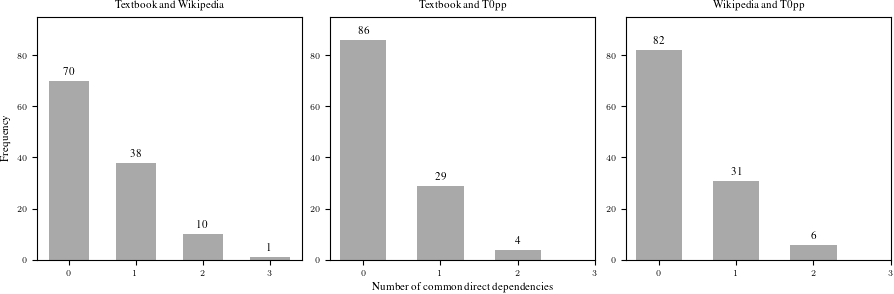

In [15]:
# Graphs for the paper if necessary

dep_freqs = deps.loc[filter]
dep_freqs = dep_freqs.iloc[:,-3:].apply(pd.Series.value_counts)

figs, ax = plt.subplots(1, 3, figsize=(9,3))

ax[0].set_title("Textbook and Wikipedia")
rects = ax[0].bar(dep_freqs.index,dep_freqs['num_common_tb_wiki'],width=0.6, color="darkgrey")
ax[0].bar_label(rects, padding=3)
ax[0].set_ylabel('Frequency')
ax[0].set_xticks(dep_freqs.index)
ax[0].set_ylim(0, 95)

ax[1].set_title("Textbook and T0pp")
rects = ax[1].bar(dep_freqs.index,dep_freqs['num_common_tb_llm'],width=0.6, color="darkgrey")
ax[1].bar_label(rects, padding=3)
ax[1].set_xticks(dep_freqs.index)
ax[1].set_ylim(0, 95)

ax[2].set_title("Wikipedia and T0pp")
rects = ax[2].bar(dep_freqs.index,dep_freqs['num_common_llm_wiki'],width=0.6, color="darkgrey")
ax[2].bar_label(rects, padding=3)
ax[2].set_xticks(dep_freqs.index)
ax[2].set_ylim(0, 95)

ax[1].set_xlabel('Number of common direct dependencies')
plt.show()

In [16]:
figs.savefig("../doc/img/comp_direct_deps.pdf", format="pdf")

#### 1.2. Second-order dependencies

In [17]:
def get_2orderdeps(dep_articles,colname):
    deps2lev = deps.loc[deps['concept'].isin(dep_articles),colname].to_list()
    if deps2lev:
        if isinstance(deps2lev[0],list):
            deps2_lev_flat=[dep for dep_list in deps2lev for dep in dep_list]
            return deps2_lev_flat + dep_articles
        else:    
            return list(set(deps2lev[0]+dep_articles))
    else:
        return dep_articles


deps['deps_tb_2'] = deps['dep_articles_textbook'].apply(lambda x: get_2orderdeps(x,'dep_articles_textbook'))
deps['deps_llm_2'] = deps['dep_articles_llm'].apply(lambda x: get_2orderdeps(x,'dep_articles_llm'))
deps['deps_wiki_2'] = deps['dep_articles_wiki'].apply(lambda x: get_2orderdeps(x, 'dep_articles_wiki'))

deps['num_common_tb_wiki_2'] = deps.apply(lambda r: get_number_common_concepts(r.concept, r['deps_tb_2'], r['deps_wiki_2']), axis=1)
deps['num_common_tb_llm_2'] = deps.apply(lambda r: get_number_common_concepts(r.concept, r['deps_tb_2'], r['deps_llm_2']), axis=1)
deps['num_common_llm_wiki_2'] = deps.apply(lambda r: get_number_common_concepts(r.concept, r['deps_llm_2'], r['deps_wiki_2']), axis=1)



In [18]:
# Graphs for presentation

fig = make_subplots(rows=1, cols=3,subplot_titles=("Textbooks and Wikipedia","Textbooks and T0pp", "T0pp and Wikipedia"))

trace0 = go.Histogram(x=deps.loc[filter,'num_common_tb_wiki_2'],texttemplate="%{y}",marker_color = "#BC602D",xbins_size=0.5)
trace1 = go.Histogram(x=deps.loc[filter,'num_common_tb_llm_2'],texttemplate="%{y}",marker_color = "#BC602D",xbins_size=0.5)
trace2 = go.Histogram(x=deps.loc[filter,'num_common_llm_wiki_2'],texttemplate="%{y}",marker_color = "#BC602D",xbins_size=0.5)

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace2, 1, 3)

#fig.update_xaxes(title_text="# of common direct+2nd-level dependencies",  row=1, col=1)
fig.update_yaxes(title_text="Frequency", row=1, col=1)
fig.update_xaxes(title_text="# of common direct  and second-level dependencies",  row=1, col=2)
#fig.update_xaxes(title_text="# of common direct+2nd-level dependencies",  row=1, col=3)

fig.update_layout({
"plot_bgcolor": "rgba(0, 0, 0, 0)",
"paper_bgcolor": "rgba(0, 0, 0, 0)",
}, showlegend=False)

fig.show()

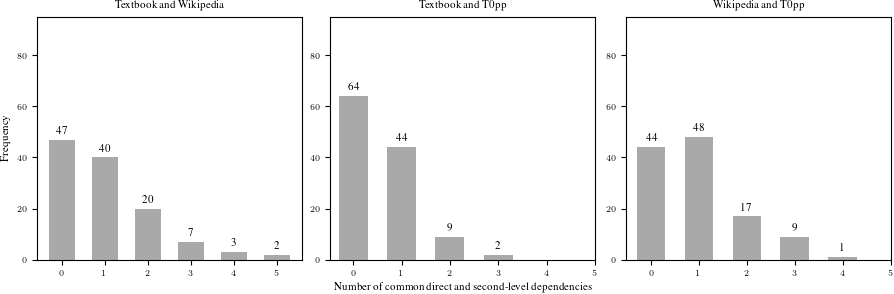

In [19]:
# Graphs for the paper if necessary

dep_freqs = deps.loc[filter]
dep_freqs = dep_freqs.iloc[:,-3:].apply(pd.Series.value_counts)

figs, ax = plt.subplots(1, 3, figsize=(9,3))

ax[0].set_title("Textbook and Wikipedia")
rects = ax[0].bar(dep_freqs.index,dep_freqs['num_common_tb_wiki_2'],width=0.6, color="darkgrey")
ax[0].bar_label(rects, padding=3)
ax[0].set_ylabel('Frequency')
ax[0].set_xticks(dep_freqs.index)
ax[0].set_ylim(0, 95)

ax[1].set_title("Textbook and T0pp")
rects = ax[1].bar(dep_freqs.index,dep_freqs['num_common_tb_llm_2'],width=0.6, color="darkgrey")
ax[1].bar_label(rects, padding=3)
ax[1].set_xticks(dep_freqs.index)
ax[1].set_ylim(0, 95)

ax[2].set_title("Wikipedia and T0pp")
rects = ax[2].bar(dep_freqs.index,dep_freqs['num_common_llm_wiki_2'],width=0.6, color="darkgrey")
ax[2].bar_label(rects, padding=3)
ax[2].set_xticks(dep_freqs.index)
ax[2].set_ylim(0, 95)

ax[1].set_xlabel('Number of common direct  and second-level dependencies')
plt.show()

In [20]:
figs.savefig("../doc/img/comp_second_deps.pdf", format="pdf")

### Precision: 1st, 2nd and 3rd - order dependencies

In [21]:
# +2nd and 3rd order dependencies

deps['deps_tb_3'] = deps['deps_tb_2'].apply(lambda x: get_2orderdeps(x,'dep_articles_textbook'))
deps['deps_llm_3'] = deps['deps_llm_2'].apply(lambda x: get_2orderdeps(x,'dep_articles_llm'))
deps['deps_wiki_3'] = deps['deps_wiki_2'].apply(lambda x: get_2orderdeps(x, 'dep_articles_wiki'))

deps['num_common_tb_wiki_3'] = deps.apply(lambda r: get_number_common_concepts(r.concept, r['deps_tb_3'], r['deps_wiki_3']), axis=1)
deps['num_common_tb_llm_3'] = deps.apply(lambda r: get_number_common_concepts(r.concept, r['deps_tb_3'], r['deps_llm_3']), axis=1)
deps['num_common_llm_wiki_3'] = deps.apply(lambda r: get_number_common_concepts(r.concept, r['deps_llm_3'], r['deps_wiki_3']), axis=1)

deps["num_wiki_3"] = deps['deps_wiki_3'].apply(lambda x: len(x))
deps["num_llm_3"] = deps['deps_llm_3'].apply(lambda x: len(x))
deps["num_textbook_3"] = deps['deps_tb_3'].apply(lambda x: len(x))

deps["precision_tb_llm_llm_3"] = deps['num_common_tb_llm_3']/deps["num_llm_3"] 
deps["precision_llm_wiki_llm_3"] = deps['num_common_llm_wiki_3']/deps["num_llm_3"] 

In [22]:
# 1st-order dependencies
deps["num_wiki"] = deps.dep_articles_wiki.apply(lambda x: len(x))
deps["num_llm"] = deps.dep_articles_llm.apply(lambda x: len(x))
deps["num_textbook"] = deps.dep_articles_textbook.apply(lambda x: len(x))

deps["precision_tb_llm_llm_1"] = deps['num_common_tb_llm']/deps["num_llm"] 
deps["precision_llm_wiki_llm_1"] = deps['num_common_llm_wiki']/deps["num_llm"] 

# +2nd-order dependencies
deps["num_wiki_2"] = deps['deps_wiki_2'].apply(lambda x: len(x))
deps["num_llm_2"] = deps['deps_llm_2'].apply(lambda x: len(x))
deps["num_textbook_2"] = deps['deps_tb_2'].apply(lambda x: len(x))

deps["precision_tb_llm_llm_2"] = deps['num_common_tb_llm_2']/deps["num_llm_2"] 
deps["precision_llm_wiki_llm_2"] = deps['num_common_llm_wiki_2']/deps["num_llm_2"] 


deps = deps.fillna(0)

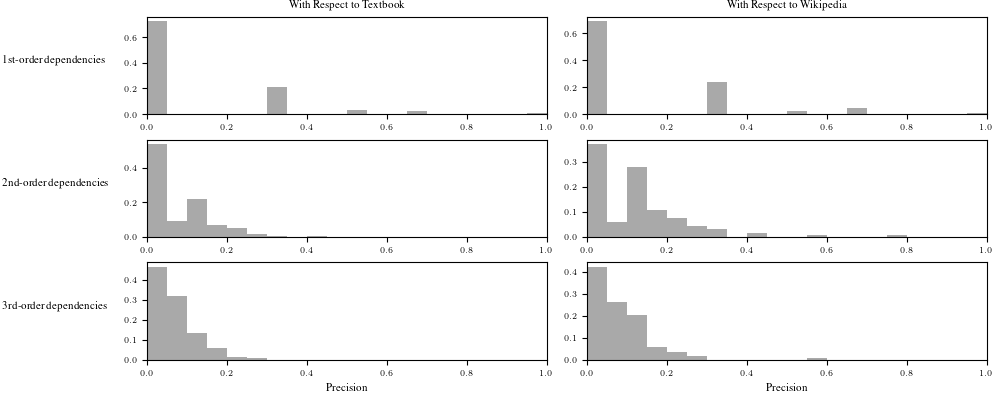

In [23]:
deps_filt = deps.loc[filter]

figs, ax = plt.subplots(3, 2, figsize=(10,4))

# 1st order
ax[0,0].set_title("With Respect to Textbook")
ax[0,0].hist(deps_filt['precision_tb_llm_llm_1'],bins=20, range = (0,1),color="darkgrey",
             weights=np.ones(len(deps_filt['precision_tb_llm_llm_1'])) / len(deps_filt['precision_tb_llm_llm_1']))
ax[0,0].set_xlim(0, 1)
ax[0,0].set_ylabel('1st-order dependencies', rotation=0, labelpad=50)

ax[0,1].set_title("With Respect to Wikipedia")
ax[0,1].hist(deps_filt['precision_llm_wiki_llm_1'],bins=20, range = (0,1), color="darkgrey",
             weights=np.ones(len(deps_filt['precision_llm_wiki_llm_1'])) / len(deps_filt['precision_llm_wiki_llm_1']))
ax[0,1].set_xlim(0, 1)

# 2nd order

ax[1,0].hist(deps_filt['precision_tb_llm_llm_2'],bins=20, range = (0,1),color="darkgrey",
             weights=np.ones(len(deps_filt['precision_tb_llm_llm_2'])) / len(deps_filt['precision_tb_llm_llm_2']))
ax[1,0].set_xlim(0, 1)
ax[1,0].set_ylabel('2nd-order dependencies', rotation=0, labelpad=50)

ax[1,1].hist(deps_filt['precision_llm_wiki_llm_2'],bins=20, range = (0,1), color="darkgrey",
             weights=np.ones(len(deps_filt['precision_llm_wiki_llm_2'])) / len(deps_filt['precision_llm_wiki_llm_2']))
ax[1,1].set_xlim(0, 1)

# 3rd order

ax[2,0].hist(deps_filt['precision_tb_llm_llm_3'],bins=20, range = (0,1),color="darkgrey",
             weights=np.ones(len(deps_filt['precision_tb_llm_llm_3'])) / len(deps_filt['precision_tb_llm_llm_3']))
ax[2,0].set_xlim(0, 1)
ax[2,0].set_ylabel('3rd-order dependencies', rotation=0, labelpad=50)

ax[2,1].hist(deps_filt['precision_llm_wiki_llm_3'],bins=20, range = (0,1), color="darkgrey",
             weights=np.ones(len(deps_filt['precision_llm_wiki_llm_3'])) / len(deps_filt['precision_llm_wiki_llm_3']))
ax[2,1].set_xlim(0, 1)


ax[2,0].set_xlabel('Precision')
ax[2,1].set_xlabel('Precision')

plt.show()

In [24]:
figs.savefig("../doc/img/precision_deps_3rd_order.pdf", format="pdf")

#### 2nd level

In [23]:
deps["num_wiki"] = deps['2levdeps_wiki'].apply(lambda x: len(x))
deps["num_llm"] = deps['2levdeps_llm'].apply(lambda x: len(x))
deps["num_textbook"] = deps['2levdeps_tb'].apply(lambda x: len(x))

deps["precision_tb_wiki_wiki"] = deps['num_common_tb_wiki2']/deps["num_wiki"] 
deps["precision_tb_wiki_tb"] = deps['num_common_tb_wiki2']/deps["num_textbook"] 
deps["precision_tb_wiki_all"] = deps['num_common_tb_wiki2']/(deps["num_textbook"]+deps["num_wiki"]-deps['num_common_tb_wiki2']) 

deps["precision_tb_llm_tb"] = deps['num_common_tb_llm2']/deps["num_textbook"] 
deps["precision_tb_llm_llm"] = deps['num_common_tb_llm2']/deps["num_llm"] 
deps["precision_tb_llm_all"] = deps['num_common_tb_llm2']/(deps["num_textbook"]+deps["num_llm"]-deps['num_common_tb_llm2']) 

deps["precision_llm_wiki_wiki"] = deps['num_common_llm_wiki2']/deps["num_wiki"] 
deps["precision_llm_wiki_llm"] = deps['num_common_llm_wiki2']/deps["num_llm"] 
deps["precision_llm_wiki_all"] = deps['num_common_llm_wiki2']/(deps["num_llm"]+deps["num_wiki"]-deps['num_common_llm_wiki2']) 

deps = deps.fillna(0)

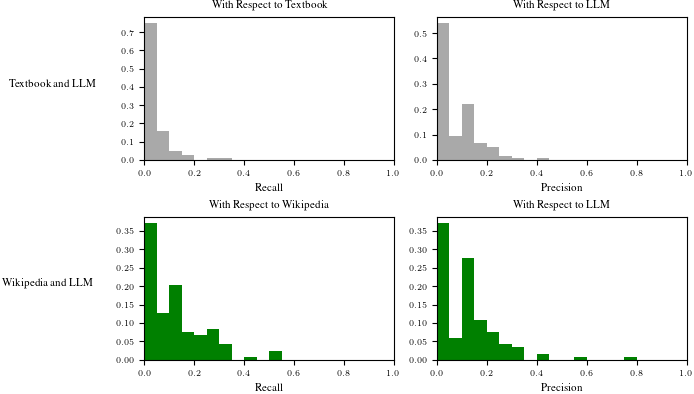

In [29]:
deps2 = deps.loc[filter]

figs, ax = plt.subplots(2, 2, figsize=(7,4))
ax[0,0].set_title("With Respect to Textbook")
ax[0,0].hist(deps2['precision_tb_llm_tb'],bins=20, range = (0,1),color="darkgrey",
             weights=np.ones(len(deps2['precision_tb_llm_tb'])) / len(deps2['precision_tb_llm_tb']))
ax[0,0].set_xlim(0, 1)

ax[0,0].set_ylabel('Textbook and LLM', rotation=0, labelpad=50)

ax[0,1].set_title("With Respect to LLM")
ax[0,1].hist(deps2['precision_tb_llm_llm'],bins=20, range = (0,1), color="darkgrey",
             weights=np.ones(len(deps2['precision_tb_llm_llm'])) / len(deps2['precision_tb_llm_llm']))
ax[0,1].set_xlim(0, 1)

#ax[0,2].set_title("With Respect to All")
#ax[0,2].hist(deps2['precision_tb_llm_all'],bins=20, range = (0,1), color="darkgrey",
#             weights=np.ones(len(deps2['precision_tb_llm_all'])) / len(deps2['precision_tb_llm_all']))
#ax[0,2].set_xlim(0, 1)


ax[1,0].set_title("With Respect to Wikipedia")
ax[1,0].hist(deps2['precision_llm_wiki_wiki'],bins=20, range = (0,1),color="green",
             weights=np.ones(len(deps2['precision_llm_wiki_wiki'])) / len(deps2['precision_llm_wiki_wiki']))
ax[1,0].set_xlim(0, 1)
ax[1,0].set_ylabel('Wikipedia and LLM', rotation=0, labelpad=50)

ax[1,1].set_title("With Respect to LLM")
ax[1,1].hist(deps2['precision_llm_wiki_llm'],bins=20, range = (0,1), color="green",
             weights=np.ones(len(deps2['precision_llm_wiki_llm'])) / len(deps2['precision_llm_wiki_llm']))
ax[1,1].set_xlim(0, 1)

#ax[1,2].set_title("With Respect to All")
#ax[1,2].hist(deps2['precision_llm_wiki_all'],bins=20, range = (0,1), color="green",
#             weights=np.ones(len(deps2['precision_llm_wiki_all'])) / len(deps2['precision_llm_wiki_all']))
#ax[1,2].set_xlim(0, 1)

ax[0,1].set_xlabel('Precision')
ax[1,1].set_xlabel('Precision')
ax[0,0].set_xlabel('Recall')
ax[1,0].set_xlabel('Recall')

plt.show()

In [30]:
figs.savefig("../doc/img/precision_deps_2level.pdf", format="pdf")